In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 5
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

Date  wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
0  1/1/1979  5.531398           0.811961  186.687054    3.127880  1.009872   
1  2/1/1979  5.328020           0.688896  174.794571   18.541594  0.920831   
2  3/1/1979  5.432511           0.916124  190.741933   67.690429  0.983327   
3  4/1/1979  4.792836           1.272056  212.937925  156.223673  0.890723   
4  5/1/1979  4.819028           2.239776  253.690478  230.950833  1.201308   

   snowfall         sst         t2m  surface_pressure  sea_ice_extent  
0  0.892319  273.355237  250.388101        984.633032        15604191  
1  0.781347  273.121885  247.071202        983.980418        16378929  
2  0.855266  273.088099  252.954138        985.140468        16521089  
3  0.705203  273.126062  259.557456        989.314698        15561238  
4  0.688723  273.393551  269.375118        984.483658        14085613

In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df.tail(len(df))

wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
Date                                                                        
1979-01-01  5.531398           0.811961  186.687054    3.127880  1.009872   
1979-02-01  5.328020           0.688896  174.794571   18.541594  0.920831   
1979-03-01  5.432511           0.916124  190.741933   67.690429  0.983327   
1979-04-01  4.792836           1.272056  212.937925  156.223673  0.890723   
1979-05-01  4.819028           2.239776  253.690478  230.950833  1.201308   
...              ...                ...         ...         ...       ...   
2021-04-01  5.383687           1.529497  225.171796  156.567743  1.159049   
2021-05-01  4.777020           2.451088  260.956781  229.604138  1.077705   
2021-06-01  4.771453           4.176458  294.931709  244.702852  1.585094   
2021-07-01  4.754014           5.193846  313.311345  196.774631  1.957911   
2021-08-01  4.635243           5.077386  313.003568  126.146891  2.046782   

            snowfall         sst         t2m  surface_pressure  sea_ice_extent  
Date                                                                            
1979-01-01  0.892319  273.355237  250.388101        984.633032      15604191.0  
1979-02-01  0.781347  273.121885  247.071202        983.980418      16378929.0  
1979-03-01  0.855266  273.088099  252.954138        985.140468      16521089.0  
1979-04-01  0.705203  273.126062  259.557456        989.314698      15561238.0  
1979-05-01  0.688723  273.393551  269.375118        984.483658      14085613.0  
...              ...         ...         ...               ...             ...  
2021-04-01  0.929777  273.470298  263.146395        985.801841      13840000.0  
2021-05-01  0.575494  273.888627  271.557464        985.606182      12660000.0  
2021-06-01  0.360146  275.245088  278.360921        978.436682      10710000.0  
2021-07-01  0.248088  277.253314  280.413695        978.293303       7690000.0  
2021-08-01  0.235519  278.556142  279.556077        980.453507       5750000.0  

[512 rows x 10 columns]

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

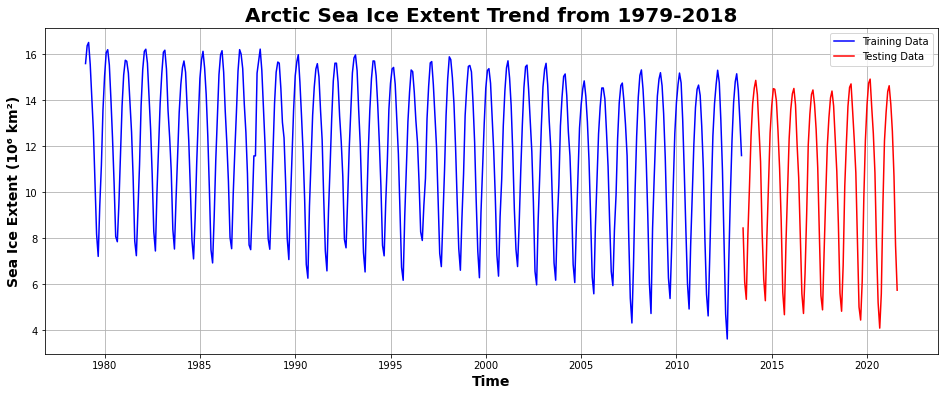

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 21, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 21, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 21, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 21, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 21, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.9394 - mae: 0.7391 - mse: 0.9394

6/6 [==============================] - 16s 537ms/step - loss: 0.9394 - mae: 0.7391 - mse: 0.9394 - val_loss: 0.1769 - val_mae: 0.3656 - val_mse: 0.1769
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1044 - mae: 0.2665 - mse: 0.1044

6/6 [==============================] - 0s 61ms/step - loss: 0.1038 - mae: 0.2669 - mse: 0.1038 - val_loss: 0.0777 - val_mae: 0.2423 - val_mse: 0.0777
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0709 - mae: 0.2276 - mse: 0.0709

6/6 [==============================] - 0s 50ms/step - loss: 0.0712 - mae: 0.2278 - mse: 0.0712 - val_loss: 0.0935 - val_mae: 0.2371 - val_mse: 0.0935
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0680 - mae: 0.2187 - mse: 0.0680

6/6 [==============================] - 0s 48ms/step - loss: 0.0681 - mae: 0.2200 - mse: 0.0681 - val_loss: 0.0797 - val_mae: 0.2375 - val_mse: 0.0797
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0641 - mae: 0.2092 - mse: 0.0641

6/6 [==============================] - 0s 47ms/step - loss: 0.0630 - mae: 0.2074 - mse: 0.0630 - val_loss: 0.0809 - val_mae: 0.2367 - val_mse: 0.0809
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0608 - mae: 0.2114 - mse: 0.0608

6/6 [==============================] - 0s 47ms/step - loss: 0.0595 - mae: 0.2085 - mse: 0.0595 - val_loss: 0.0784 - val_mae: 0.2386 - val_mse: 0.0784
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0634 - mae: 0.2143 - mse: 0.0634

6/6 [==============================] - 0s 47ms/step - loss: 0.0638 - mae: 0.2149 - mse: 0.0638 - val_loss: 0.0850 - val_mae: 0.2352 - val_mse: 0.0850
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0631 - mae: 0.2149 - mse: 0.0631

6/6 [==============================] - 0s 47ms/step - loss: 0.0622 - mae: 0.2135 - mse: 0.0622 - val_loss: 0.0804 - val_mae: 0.2369 - val_mse: 0.0804
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0630 - mae: 0.2127 - mse: 0.0630

6/6 [==============================] - 0s 48ms/step - loss: 0.0643 - mae: 0.2153 - mse: 0.0643 - val_loss: 0.0794 - val_mae: 0.2377 - val_mse: 0.0794
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0615 - mae: 0.2109 - mse: 0.0615

6/6 [==============================] - 0s 47ms/step - loss: 0.0630 - mae: 0.2140 - mse: 0.0630 - val_loss: 0.0789 - val_mae: 0.2381 - val_mse: 0.0789
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0601 - mae: 0.2092 - mse: 0.0601

6/6 [==============================] - 0s 48ms/step - loss: 0.0598 - mae: 0.2093 - mse: 0.0598 - val_loss: 0.0796 - val_mae: 0.2375 - val_mse: 0.0796
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0599 - mae: 0.2132 - mse: 0.0599

6/6 [==============================] - 0s 47ms/step - loss: 0.0606 - mae: 0.2142 - mse: 0.0606 - val_loss: 0.0810 - val_mae: 0.2366 - val_mse: 0.0810
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0603 - mae: 0.2029 - mse: 0.0603

6/6 [==============================] - 0s 47ms/step - loss: 0.0601 - mae: 0.2022 - mse: 0.0601 - val_loss: 0.0810 - val_mae: 0.2366 - val_mse: 0.0810
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0602 - mae: 0.2124 - mse: 0.0602

6/6 [==============================] - 0s 48ms/step - loss: 0.0604 - mae: 0.2126 - mse: 0.0604 - val_loss: 0.0773 - val_mae: 0.2400 - val_mse: 0.0773
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0616 - mae: 0.2110 - mse: 0.0616

6/6 [==============================] - 0s 46ms/step - loss: 0.0597 - mae: 0.2065 - mse: 0.0597 - val_loss: 0.0863 - val_mae: 0.2352 - val_mse: 0.0863
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0630 - mae: 0.2102 - mse: 0.0630

6/6 [==============================] - 0s 48ms/step - loss: 0.0621 - mae: 0.2094 - mse: 0.0621 - val_loss: 0.0777 - val_mae: 0.2393 - val_mse: 0.0777
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0603 - mae: 0.2119 - mse: 0.0603

6/6 [==============================] - 0s 47ms/step - loss: 0.0619 - mae: 0.2145 - mse: 0.0619 - val_loss: 0.0787 - val_mae: 0.2382 - val_mse: 0.0787
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0614 - mae: 0.2140 - mse: 0.0614

6/6 [==============================] - 0s 47ms/step - loss: 0.0615 - mae: 0.2149 - mse: 0.0615 - val_loss: 0.0801 - val_mae: 0.2372 - val_mse: 0.0801
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0613 - mae: 0.2099 - mse: 0.0613

6/6 [==============================] - 0s 49ms/step - loss: 0.0607 - mae: 0.2091 - mse: 0.0607 - val_loss: 0.0812 - val_mae: 0.2364 - val_mse: 0.0812
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0614 - mae: 0.2139 - mse: 0.0614

6/6 [==============================] - 0s 49ms/step - loss: 0.0601 - mae: 0.2116 - mse: 0.0601 - val_loss: 0.0782 - val_mae: 0.2387 - val_mse: 0.0782
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0594 - mae: 0.2067 - mse: 0.0594

6/6 [==============================] - 0s 47ms/step - loss: 0.0586 - mae: 0.2055 - mse: 0.0586 - val_loss: 0.0818 - val_mae: 0.2361 - val_mse: 0.0818
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0603 - mae: 0.2091 - mse: 0.0603

6/6 [==============================] - 0s 46ms/step - loss: 0.0587 - mae: 0.2065 - mse: 0.0587 - val_loss: 0.0806 - val_mae: 0.2368 - val_mse: 0.0806
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0597 - mae: 0.2090 - mse: 0.0597

6/6 [==============================] - 0s 47ms/step - loss: 0.0589 - mae: 0.2078 - mse: 0.0589 - val_loss: 0.0801 - val_mae: 0.2371 - val_mse: 0.0801
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0602 - mae: 0.2105 - mse: 0.0602

6/6 [==============================] - 0s 47ms/step - loss: 0.0622 - mae: 0.2136 - mse: 0.0622 - val_loss: 0.0784 - val_mae: 0.2384 - val_mse: 0.0784
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0578 - mae: 0.2083 - mse: 0.0578

6/6 [==============================] - 0s 47ms/step - loss: 0.0589 - mae: 0.2108 - mse: 0.0589 - val_loss: 0.0808 - val_mae: 0.2366 - val_mse: 0.0808
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0596 - mae: 0.2052 - mse: 0.0596

6/6 [==============================] - 0s 46ms/step - loss: 0.0599 - mae: 0.2053 - mse: 0.0599 - val_loss: 0.0811 - val_mae: 0.2364 - val_mse: 0.0811
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0603 - mae: 0.2147 - mse: 0.0603

6/6 [==============================] - 0s 46ms/step - loss: 0.0609 - mae: 0.2158 - mse: 0.0609 - val_loss: 0.0781 - val_mae: 0.2387 - val_mse: 0.0781
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0601 - mae: 0.2108 - mse: 0.0601

6/6 [==============================] - 0s 47ms/step - loss: 0.0606 - mae: 0.2106 - mse: 0.0606 - val_loss: 0.0843 - val_mae: 0.2351 - val_mse: 0.0843
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0566 - mae: 0.2066 - mse: 0.0566

6/6 [==============================] - 0s 47ms/step - loss: 0.0564 - mae: 0.2064 - mse: 0.0564 - val_loss: 0.0773 - val_mae: 0.2397 - val_mse: 0.0773
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0585 - mae: 0.2088 - mse: 0.0585

6/6 [==============================] - 0s 48ms/step - loss: 0.0578 - mae: 0.2073 - mse: 0.0578 - val_loss: 0.0842 - val_mae: 0.2351 - val_mse: 0.0842
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.2047 - mse: 0.0577

6/6 [==============================] - 0s 47ms/step - loss: 0.0583 - mae: 0.2068 - mse: 0.0583 - val_loss: 0.0785 - val_mae: 0.2382 - val_mse: 0.0785
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0581 - mae: 0.2071 - mse: 0.0581

6/6 [==============================] - 0s 47ms/step - loss: 0.0577 - mae: 0.2064 - mse: 0.0577 - val_loss: 0.0793 - val_mae: 0.2373 - val_mse: 0.0793
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0587 - mae: 0.2079 - mse: 0.0587

6/6 [==============================] - 0s 48ms/step - loss: 0.0601 - mae: 0.2109 - mse: 0.0601 - val_loss: 0.0785 - val_mae: 0.2379 - val_mse: 0.0785
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0582 - mae: 0.2078 - mse: 0.0582

6/6 [==============================] - 0s 47ms/step - loss: 0.0592 - mae: 0.2096 - mse: 0.0592 - val_loss: 0.0821 - val_mae: 0.2354 - val_mse: 0.0821
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0568 - mae: 0.2034 - mse: 0.0568

6/6 [==============================] - 0s 48ms/step - loss: 0.0589 - mae: 0.2066 - mse: 0.0589 - val_loss: 0.0782 - val_mae: 0.2371 - val_mse: 0.0782
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1640 - mae: 0.2806 - mse: 0.1640

6/6 [==============================] - 0s 47ms/step - loss: 0.1559 - mae: 0.2747 - mse: 0.1559 - val_loss: 0.0451 - val_mae: 0.1839 - val_mse: 0.0451
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0948 - mae: 0.2334 - mse: 0.0948

6/6 [==============================] - 0s 47ms/step - loss: 0.0890 - mae: 0.2242 - mse: 0.0890 - val_loss: 0.0338 - val_mae: 0.1459 - val_mse: 0.0338
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0325 - mae: 0.1459 - mse: 0.0325

6/6 [==============================] - 0s 48ms/step - loss: 0.0320 - mae: 0.1453 - mse: 0.0320 - val_loss: 0.0344 - val_mae: 0.1462 - val_mse: 0.0344
Epoch 39/100
6/6 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.1330 - mse: 0.0263

6/6 [==============================] - 0s 51ms/step - loss: 0.0263 - mae: 0.1330 - mse: 0.0263 - val_loss: 0.0220 - val_mae: 0.1151 - val_mse: 0.0220
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0226 - mae: 0.1247 - mse: 0.0226

6/6 [==============================] - 0s 49ms/step - loss: 0.0227 - mae: 0.1246 - mse: 0.0227 - val_loss: 0.0234 - val_mae: 0.1207 - val_mse: 0.0234
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0214 - mae: 0.1173 - mse: 0.0214

6/6 [==============================] - 0s 47ms/step - loss: 0.0213 - mae: 0.1170 - mse: 0.0213 - val_loss: 0.0220 - val_mae: 0.1161 - val_mse: 0.0220
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0213 - mae: 0.1223 - mse: 0.0213

6/6 [==============================] - 0s 46ms/step - loss: 0.0209 - mae: 0.1205 - mse: 0.0209 - val_loss: 0.0219 - val_mae: 0.1125 - val_mse: 0.0219
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0206 - mae: 0.1175 - mse: 0.0206

6/6 [==============================] - 0s 46ms/step - loss: 0.0206 - mae: 0.1177 - mse: 0.0206 - val_loss: 0.0202 - val_mae: 0.1137 - val_mse: 0.0202
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0358 - mae: 0.1476 - mse: 0.0358

6/6 [==============================] - 0s 48ms/step - loss: 0.0387 - mae: 0.1548 - mse: 0.0387 - val_loss: 0.0540 - val_mae: 0.1828 - val_mse: 0.0540
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0491 - mae: 0.1687 - mse: 0.0491

6/6 [==============================] - 0s 47ms/step - loss: 0.0481 - mae: 0.1676 - mse: 0.0481 - val_loss: 0.0779 - val_mae: 0.2491 - val_mse: 0.0779
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0566 - mae: 0.1958 - mse: 0.0566

6/6 [==============================] - 0s 47ms/step - loss: 0.0554 - mae: 0.1938 - mse: 0.0554 - val_loss: 0.0826 - val_mae: 0.2299 - val_mse: 0.0826
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0604 - mae: 0.2060 - mse: 0.0604

6/6 [==============================] - 0s 48ms/step - loss: 0.0609 - mae: 0.2080 - mse: 0.0609 - val_loss: 0.0768 - val_mae: 0.2403 - val_mse: 0.0768
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0569 - mae: 0.2020 - mse: 0.0569

6/6 [==============================] - 0s 47ms/step - loss: 0.0556 - mae: 0.1991 - mse: 0.0556 - val_loss: 0.0534 - val_mae: 0.1728 - val_mse: 0.0534
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0329 - mae: 0.1410 - mse: 0.0329

6/6 [==============================] - 0s 47ms/step - loss: 0.0316 - mae: 0.1378 - mse: 0.0316 - val_loss: 0.0312 - val_mae: 0.1330 - val_mse: 0.0312
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0218 - mae: 0.1165 - mse: 0.0218

6/6 [==============================] - 0s 48ms/step - loss: 0.0214 - mae: 0.1160 - mse: 0.0214 - val_loss: 0.0269 - val_mae: 0.1235 - val_mse: 0.0269
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0196 - mae: 0.1122 - mse: 0.0196

6/6 [==============================] - 0s 47ms/step - loss: 0.0194 - mae: 0.1118 - mse: 0.0194 - val_loss: 0.0293 - val_mae: 0.1221 - val_mse: 0.0293
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0189 - mae: 0.1097 - mse: 0.0189

6/6 [==============================] - 0s 48ms/step - loss: 0.0190 - mae: 0.1105 - mse: 0.0190 - val_loss: 0.0236 - val_mae: 0.1156 - val_mse: 0.0236
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0182 - mae: 0.1073 - mse: 0.0182

6/6 [==============================] - 0s 47ms/step - loss: 0.0177 - mae: 0.1060 - mse: 0.0177 - val_loss: 0.0253 - val_mae: 0.1177 - val_mse: 0.0253
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0172 - mae: 0.1040 - mse: 0.0172

6/6 [==============================] - 0s 48ms/step - loss: 0.0179 - mae: 0.1075 - mse: 0.0179 - val_loss: 0.0257 - val_mae: 0.1174 - val_mse: 0.0257
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0164 - mae: 0.1018 - mse: 0.0164

6/6 [==============================] - 0s 47ms/step - loss: 0.0171 - mae: 0.1047 - mse: 0.0171 - val_loss: 0.0249 - val_mae: 0.1151 - val_mse: 0.0249
Epoch 56/100
6/6 [==============================] - ETA: 0s - loss: 0.0167 - mae: 0.1037 - mse: 0.0167

6/6 [==============================] - 0s 48ms/step - loss: 0.0167 - mae: 0.1037 - mse: 0.0167 - val_loss: 0.0248 - val_mae: 0.1147 - val_mse: 0.0248
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0178 - mae: 0.1049 - mse: 0.0178

6/6 [==============================] - 0s 47ms/step - loss: 0.0175 - mae: 0.1039 - mse: 0.0175 - val_loss: 0.0244 - val_mae: 0.1125 - val_mse: 0.0244
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0157 - mae: 0.1006 - mse: 0.0157

6/6 [==============================] - 0s 48ms/step - loss: 0.0166 - mae: 0.1032 - mse: 0.0166 - val_loss: 0.0247 - val_mae: 0.1123 - val_mse: 0.0247
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0182 - mae: 0.1089 - mse: 0.0182

6/6 [==============================] - 0s 47ms/step - loss: 0.0176 - mae: 0.1066 - mse: 0.0176 - val_loss: 0.0226 - val_mae: 0.1093 - val_mse: 0.0226
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0182 - mae: 0.1087 - mse: 0.0182

6/6 [==============================] - 0s 48ms/step - loss: 0.0179 - mae: 0.1082 - mse: 0.0179 - val_loss: 0.0225 - val_mae: 0.1079 - val_mse: 0.0225
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0172 - mae: 0.1036 - mse: 0.0172

6/6 [==============================] - 0s 47ms/step - loss: 0.0179 - mae: 0.1053 - mse: 0.0179 - val_loss: 0.0246 - val_mae: 0.1108 - val_mse: 0.0246
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0176 - mae: 0.1050 - mse: 0.0176

6/6 [==============================] - 0s 47ms/step - loss: 0.0173 - mae: 0.1035 - mse: 0.0173 - val_loss: 0.0215 - val_mae: 0.1047 - val_mse: 0.0215
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0199 - mae: 0.1101 - mse: 0.0199

6/6 [==============================] - 0s 48ms/step - loss: 0.0191 - mae: 0.1077 - mse: 0.0191 - val_loss: 0.0226 - val_mae: 0.1069 - val_mse: 0.0226
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0182 - mae: 0.1081 - mse: 0.0182

6/6 [==============================] - 0s 47ms/step - loss: 0.0178 - mae: 0.1064 - mse: 0.0178 - val_loss: 0.0239 - val_mae: 0.1087 - val_mse: 0.0239
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0175 - mae: 0.1044 - mse: 0.0175

6/6 [==============================] - 0s 48ms/step - loss: 0.0171 - mae: 0.1034 - mse: 0.0171 - val_loss: 0.0257 - val_mae: 0.1104 - val_mse: 0.0257
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0177 - mae: 0.1074 - mse: 0.0177

6/6 [==============================] - 0s 46ms/step - loss: 0.0177 - mae: 0.1077 - mse: 0.0177 - val_loss: 0.0230 - val_mae: 0.1090 - val_mse: 0.0230
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0163 - mae: 0.1027 - mse: 0.0163

6/6 [==============================] - 0s 48ms/step - loss: 0.0165 - mae: 0.1036 - mse: 0.0165 - val_loss: 0.0220 - val_mae: 0.1047 - val_mse: 0.0220
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0156 - mae: 0.0998 - mse: 0.0156

6/6 [==============================] - 0s 47ms/step - loss: 0.0161 - mae: 0.1004 - mse: 0.0161 - val_loss: 0.0229 - val_mae: 0.1051 - val_mse: 0.0229
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0154 - mae: 0.0988 - mse: 0.0154

6/6 [==============================] - 0s 47ms/step - loss: 0.0154 - mae: 0.0996 - mse: 0.0154 - val_loss: 0.0204 - val_mae: 0.1016 - val_mse: 0.0204
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0163 - mae: 0.0985 - mse: 0.0163

6/6 [==============================] - 0s 47ms/step - loss: 0.0160 - mae: 0.0981 - mse: 0.0160 - val_loss: 0.0223 - val_mae: 0.1033 - val_mse: 0.0223
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0170 - mae: 0.1007 - mse: 0.0170

6/6 [==============================] - 0s 47ms/step - loss: 0.0163 - mae: 0.0987 - mse: 0.0163 - val_loss: 0.0233 - val_mae: 0.1094 - val_mse: 0.0233
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0160 - mae: 0.0983 - mse: 0.0160

6/6 [==============================] - 0s 49ms/step - loss: 0.0160 - mae: 0.0986 - mse: 0.0160 - val_loss: 0.0201 - val_mae: 0.1038 - val_mse: 0.0201
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0163 - mae: 0.0999 - mse: 0.0163

6/6 [==============================] - 0s 48ms/step - loss: 0.0164 - mae: 0.1004 - mse: 0.0164 - val_loss: 0.0222 - val_mae: 0.1030 - val_mse: 0.0222
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0154 - mae: 0.0975 - mse: 0.0154

6/6 [==============================] - 0s 48ms/step - loss: 0.0154 - mae: 0.0982 - mse: 0.0154 - val_loss: 0.0239 - val_mae: 0.1129 - val_mse: 0.0239
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0172 - mae: 0.1018 - mse: 0.0172

6/6 [==============================] - 0s 48ms/step - loss: 0.0170 - mae: 0.1013 - mse: 0.0170 - val_loss: 0.0207 - val_mae: 0.1049 - val_mse: 0.0207
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0152 - mae: 0.0945 - mse: 0.0152

6/6 [==============================] - 0s 47ms/step - loss: 0.0158 - mae: 0.0962 - mse: 0.0158 - val_loss: 0.0207 - val_mae: 0.1045 - val_mse: 0.0207
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0163 - mae: 0.1003 - mse: 0.0163

6/6 [==============================] - 0s 46ms/step - loss: 0.0167 - mae: 0.1015 - mse: 0.0167 - val_loss: 0.0215 - val_mae: 0.1025 - val_mse: 0.0215
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0163 - mae: 0.0992 - mse: 0.0163

6/6 [==============================] - 0s 48ms/step - loss: 0.0160 - mae: 0.0979 - mse: 0.0160 - val_loss: 0.0211 - val_mae: 0.1034 - val_mse: 0.0211
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0153 - mae: 0.0968 - mse: 0.0153

6/6 [==============================] - 0s 47ms/step - loss: 0.0156 - mae: 0.0982 - mse: 0.0156 - val_loss: 0.0253 - val_mae: 0.1214 - val_mse: 0.0253
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0169 - mae: 0.1013 - mse: 0.0169

6/6 [==============================] - 0s 48ms/step - loss: 0.0169 - mae: 0.1021 - mse: 0.0169 - val_loss: 0.0204 - val_mae: 0.0989 - val_mse: 0.0204
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0158 - mae: 0.0985 - mse: 0.0158

6/6 [==============================] - 0s 46ms/step - loss: 0.0157 - mae: 0.0983 - mse: 0.0157 - val_loss: 0.0224 - val_mae: 0.1090 - val_mse: 0.0224
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0167 - mae: 0.0986 - mse: 0.0167

6/6 [==============================] - 0s 48ms/step - loss: 0.0166 - mae: 0.0984 - mse: 0.0166 - val_loss: 0.0239 - val_mae: 0.1057 - val_mse: 0.0239
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0169 - mae: 0.1027 - mse: 0.0169

6/6 [==============================] - 0s 49ms/step - loss: 0.0162 - mae: 0.1005 - mse: 0.0162 - val_loss: 0.0244 - val_mae: 0.1079 - val_mse: 0.0244
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0165 - mae: 0.1009 - mse: 0.0165

6/6 [==============================] - 0s 48ms/step - loss: 0.0160 - mae: 0.0989 - mse: 0.0160 - val_loss: 0.0202 - val_mae: 0.0999 - val_mse: 0.0202
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0160 - mae: 0.0989 - mse: 0.0160

6/6 [==============================] - 0s 46ms/step - loss: 0.0155 - mae: 0.0968 - mse: 0.0155 - val_loss: 0.0228 - val_mae: 0.1081 - val_mse: 0.0228
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0141 - mae: 0.0913 - mse: 0.0141

6/6 [==============================] - 0s 48ms/step - loss: 0.0152 - mae: 0.0944 - mse: 0.0152 - val_loss: 0.0230 - val_mae: 0.1034 - val_mse: 0.0230
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0157 - mae: 0.0956 - mse: 0.0157

6/6 [==============================] - 0s 47ms/step - loss: 0.0156 - mae: 0.0958 - mse: 0.0156 - val_loss: 0.0230 - val_mae: 0.1042 - val_mse: 0.0230
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0157 - mae: 0.0979 - mse: 0.0157

6/6 [==============================] - 0s 47ms/step - loss: 0.0152 - mae: 0.0967 - mse: 0.0152 - val_loss: 0.0234 - val_mae: 0.1102 - val_mse: 0.0234
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0160 - mae: 0.0975 - mse: 0.0160

6/6 [==============================] - 0s 47ms/step - loss: 0.0156 - mae: 0.0963 - mse: 0.0156 - val_loss: 0.0205 - val_mae: 0.0957 - val_mse: 0.0205
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0147 - mae: 0.0921 - mse: 0.0147

6/6 [==============================] - 0s 48ms/step - loss: 0.0143 - mae: 0.0913 - mse: 0.0143 - val_loss: 0.0208 - val_mae: 0.1002 - val_mse: 0.0208
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0357 - mae: 0.1471 - mse: 0.0357

6/6 [==============================] - 0s 49ms/step - loss: 0.0347 - mae: 0.1459 - mse: 0.0347 - val_loss: 0.0214 - val_mae: 0.1125 - val_mse: 0.0214
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0232 - mae: 0.1222 - mse: 0.0232

6/6 [==============================] - 0s 45ms/step - loss: 0.0225 - mae: 0.1202 - mse: 0.0225 - val_loss: 0.0244 - val_mae: 0.1162 - val_mse: 0.0244
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0162 - mae: 0.1039 - mse: 0.0162

6/6 [==============================] - 0s 48ms/step - loss: 0.0159 - mae: 0.1029 - mse: 0.0159 - val_loss: 0.0151 - val_mae: 0.0883 - val_mse: 0.0151
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0152 - mae: 0.0990 - mse: 0.0152

6/6 [==============================] - 0s 47ms/step - loss: 0.0150 - mae: 0.0980 - mse: 0.0150 - val_loss: 0.0229 - val_mae: 0.1111 - val_mse: 0.0229
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0140 - mae: 0.0967 - mse: 0.0140

6/6 [==============================] - 0s 47ms/step - loss: 0.0141 - mae: 0.0974 - mse: 0.0141 - val_loss: 0.0155 - val_mae: 0.0905 - val_mse: 0.0155
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0146 - mae: 0.0978 - mse: 0.0146

6/6 [==============================] - 0s 47ms/step - loss: 0.0144 - mae: 0.0975 - mse: 0.0144 - val_loss: 0.0159 - val_mae: 0.0865 - val_mse: 0.0159
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0127 - mae: 0.0894 - mse: 0.0127

6/6 [==============================] - 0s 47ms/step - loss: 0.0124 - mae: 0.0885 - mse: 0.0124 - val_loss: 0.0113 - val_mae: 0.0740 - val_mse: 0.0113
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0127 - mae: 0.0888 - mse: 0.0127

6/6 [==============================] - 0s 47ms/step - loss: 0.0127 - mae: 0.0891 - mse: 0.0127 - val_loss: 0.0188 - val_mae: 0.1031 - val_mse: 0.0188
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0133 - mae: 0.0938 - mse: 0.0133

6/6 [==============================] - 0s 47ms/step - loss: 0.0140 - mae: 0.0953 - mse: 0.0140 - val_loss: 0.0203 - val_mae: 0.0986 - val_mse: 0.0203
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0123 - mae: 0.0864 - mse: 0.0123

6/6 [==============================] - 0s 48ms/step - loss: 0.0120 - mae: 0.0861 - mse: 0.0120 - val_loss: 0.0146 - val_mae: 0.0861 - val_mse: 0.0146


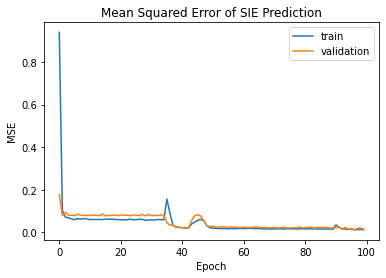

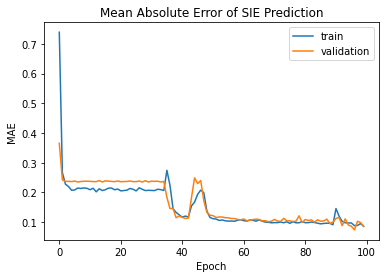

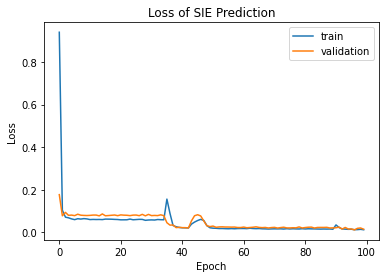

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 4s 20ms/step


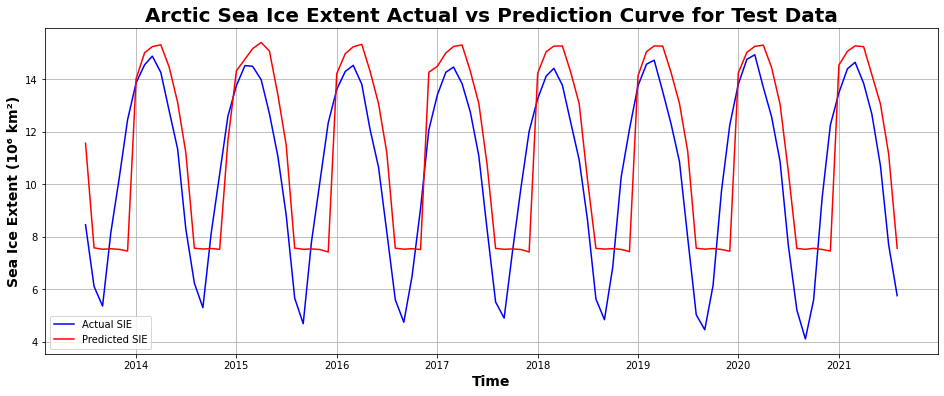

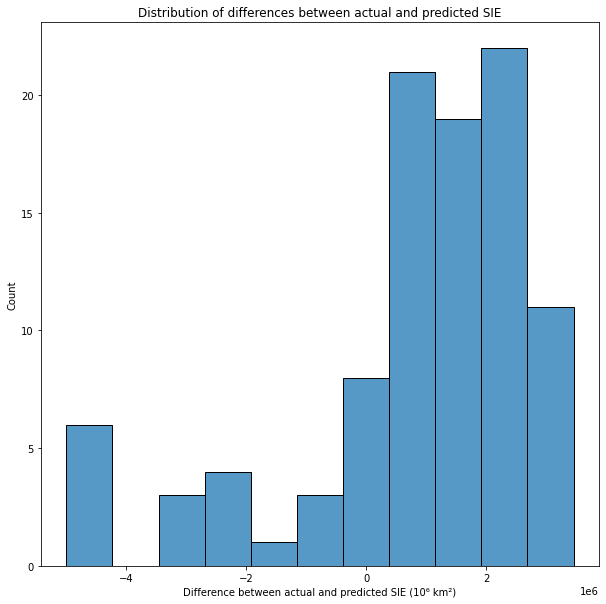

MSE :  4722075768230.168 (10⁶ km²)
MSPE : 7.541 %
RMSE :  2173033.770614292 (10⁶ km²)
RMSPE : 27.462 %
MAE :  1845373.4081632653 (10⁶ km²)
MAPE :  19.522 %
R2 :  58.07


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass